In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import cartopy.crs as ccrs
import xgcm
from xgcm.autogenerate import generate_grid_ds
from cmocean import cm

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *
from dask import compute, delayed

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py:137: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  RuntimeWarning,


In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
#print(cluster.job_script())
#print(cluster.job_header)
w = cluster.scale(14*3)

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

<Client: 'tcp://10.148.1.65:56456' processes=35 threads=35, memory=599.90 GB>

________________

# RMS of Tau


In [5]:
out_dir_zarr = '/home/datawork-lops-osi/equinox/mit4320/zarr/'
store_dir_zarr = '/home/c11-data/Test_aponte/xiaolong/TAU/rms/'

In [6]:
# read rechunked data
grid = xr.open_zarr(out_dir_zarr+'grid.zarr')
ds_TAUX = xr.open_zarr(out_dir_zarr+'oceTAUX.zarr').rename({'i_g': 'i'}).isel(time=slice(0,None,24))
ds_TAUY = xr.open_zarr(out_dir_zarr+'oceTAUY.zarr').rename({'j_g': 'j'}).isel(time=slice(0,None,24))
ds_KPP = xr.open_zarr(out_dir_zarr+'KPPhbl.zarr').isel(time=slice(0,None,24))

# data merge
ds = xr.merge([ds_TAUX,ds_TAUY,ds_KPP,grid])
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90, time: 358)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    niter    (time) int64 dask.array<chunksize=(9,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2011-11-23T08:00:00 ... 2012-11-14T08:00:00
    CS       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    Depth    (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    PHrefC   (k) float32 dask.array<chunksize=(90,), meta=np.ndarray>
    PHrefF   (k_p1) float32 dask.array<chunksize=(91,), meta=np.ndarray>
    SN       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    XC       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
 

In [7]:
# coriolis term
lat = ds['YC']
omega = 7.3/100000
f_ij = 2*omega*np.sin(np.deg2rad(lat))
f_ij

<xarray.DataArray 'YC' (face: 13, j: 4320, i: 4320)>
dask.array<mul, shape=(13, 4320, 4320), dtype=float32, chunksize=(1, 4320, 4320), chunktype=numpy.ndarray>
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    CS       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    Depth    (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    SN       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    XC       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    YC       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rA       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>

In [8]:
overwrite=True
    
for face in range(13):
#for face in [1]:

    Efile = store_dir_zarr+'rms_Tau_ELD_f%02d.zarr'%(face)

    if not os.path.isdir(Efile) or overwrite:
        
        oceTAUX_rotation =  ds.oceTAUX.isel(face=face)*ds.CS.isel(face=face) - ds.oceTAUY.isel(face=face)*ds.SN.isel(face=face)
        oceTAUY_rotation =  ds.oceTAUX.isel(face=face)*ds.SN.isel(face=face) + ds.oceTAUY.isel(face=face)*ds.CS.isel(face=face)
        
        # tau_x
        oceTAUX_rms =  np.sqrt( ((oceTAUX_rotation.isel(j=slice(0 ,None, 4), i=slice(0, None, 4))/1025)**2).mean(['time']) )
        chunks = {'i': 108, 'j': 108}
        oceTAUX_rms = oceTAUX_rms.chunk(chunks)
        oceTAUX_rms = np.real(oceTAUX_rms).rename('oceTAUX_rms')
        
        # tau_y
        oceTAUY_rms = np.sqrt(( (oceTAUY_rotation.isel(j=slice(0 ,None, 4), i=slice(0, None, 4))/1025 )**2 ).mean(['time']))
        chunks = {'i': 108, 'j': 108}
        oceTAUY_rms = oceTAUY_rms.chunk(chunks)        
        oceTAUY_rms = np.real(oceTAUY_rms).rename('oceTAUY_rms')
        
        # tau
        oceTAU_rms = np.sqrt( ( (oceTAUX_rotation.isel(j=slice(0 ,None, 4), i=slice(0, None, 4))/1025)**2 + (oceTAUY_rotation.isel(j=slice(0 ,None, 4), i=slice(0, None, 4))/1025)**2 ).mean(['time']))
        chunks = {'i': 108, 'j': 108}
        oceTAU_rms = oceTAU_rms.chunk(chunks)        
        oceTAU_rms = np.real(oceTAU_rms).rename('oceTAU_rms')
        
        # kpp_h
        #KPPh_rms = np.sqrt( ((ds.KPPhbl.isel(face=face, j=slice(0 ,None, 4), i=slice(0, None, 4)))**2 ).mean(['time']))
        #chunks = {'i': 108, 'j': 108}
        #KPPh_rms = KPPh_rms.chunk(chunks)        
        #KPPh_rms = np.real(KPPh_rms).rename('KPPh_rms') 
        
        # Ekman layer depth
        ELD = 0.2*np.sqrt(np.sqrt(oceTAUX_rotation**2 + oceTAUY_rotation**2)/1025)/np.abs(f_ij.isel(face=face))
        ELD_rms = np.sqrt( ((ELD.isel(j=slice(0 ,None, 4), i=slice(0, None, 4)))**2 ).mean(['time']))
        chunks = {'i': 108, 'j': 108}
        ELD_rms = ELD_rms.chunk(chunks)        
        ELD_rms = np.real(ELD_rms).rename('ELD_rms')         
        
        # tau_x/ELD
        oceTAUX_ELD_rms =  np.sqrt( ((oceTAUX_rotation.isel(j=slice(0 ,None, 4), i=slice(0, None, 4))/ELD.isel(j=slice(0 ,None, 4), i=slice(0, None, 4))/1025)**2).mean(['time']) )
        chunks = {'i': 108, 'j': 108}
        oceTAUX_ELD_rms = oceTAUX_ELD_rms.chunk(chunks)
        oceTAUX_ELD_rms = np.real(oceTAUX_ELD_rms).rename('oceTAUX_ELD_rms')
        
        # tau_y/ELD
        oceTAUY_ELD_rms = np.sqrt(( (oceTAUY_rotation.isel(j=slice(0 ,None, 4), i=slice(0, None, 4))/ELD.isel(j=slice(0 ,None, 4), i=slice(0, None, 4))/1025 )**2 ).mean(['time']))
        chunks = {'i': 108, 'j': 108}
        oceTAUY_ELD_rms = oceTAUY_ELD_rms.chunk(chunks)        
        oceTAUY_ELD_rms = np.real(oceTAUY_ELD_rms).rename('oceTAUY_ELD_rms')        
        
        rms_all = xr.merge([oceTAUX_rms, oceTAUY_rms, oceTAU_rms, ELD_rms, oceTAUX_ELD_rms, oceTAUY_ELD_rms])
        #print(rms_all)
        
        for c in rms_all.coords:
            try:
                del E[c].encoding['chunks']
            except:
                pass        
        
        %time rms_all.to_zarr(Efile, mode='w')

        print('--- face %d done'%face)

    else:
        print('--- face %d allready computed'%face)

CPU times: user 16.1 s, sys: 768 ms, total: 16.8 s
Wall time: 22.3 s
--- face 0 done
CPU times: user 16.4 s, sys: 888 ms, total: 17.3 s
Wall time: 23.4 s
--- face 1 done
CPU times: user 16.9 s, sys: 840 ms, total: 17.8 s
Wall time: 23.8 s
--- face 2 done
CPU times: user 16.9 s, sys: 976 ms, total: 17.9 s
Wall time: 22.9 s
--- face 3 done
CPU times: user 17.2 s, sys: 832 ms, total: 18 s
Wall time: 23.7 s
--- face 4 done
CPU times: user 16.8 s, sys: 968 ms, total: 17.7 s
Wall time: 22.5 s
--- face 5 done
CPU times: user 16.7 s, sys: 716 ms, total: 17.4 s
Wall time: 22.8 s
--- face 6 done
CPU times: user 17.2 s, sys: 800 ms, total: 18 s
Wall time: 23.4 s
--- face 7 done
CPU times: user 16.7 s, sys: 724 ms, total: 17.4 s
Wall time: 21.9 s
--- face 8 done
CPU times: user 16.9 s, sys: 812 ms, total: 17.7 s
Wall time: 22 s
--- face 9 done
CPU times: user 16.7 s, sys: 892 ms, total: 17.6 s
Wall time: 22.2 s
--- face 10 done
CPU times: user 17.1 s, sys: 772 ms, total: 17.8 s
Wall time: 23.2 s
-

____________
# Read RMS

In [9]:
store_dir_zarr = '/home/c11-data/Test_aponte/xiaolong/TAU/rms/'
face_all = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

D = [xr.open_zarr(store_dir_zarr+'rms_Tau_ELD_f%02d.zarr'%(face)) for face in face_all] 
ds_TAU = xr.concat(D, dim='face')
print(ds_TAU) 
print('\n data size: %.1f GB' %(ds_TAU.nbytes / 1e9))

<xarray.Dataset>
Dimensions:          (face: 13, i: 1080, j: 1080)
Coordinates:
  * j                (j) int64 0 4 8 12 16 20 ... 4296 4300 4304 4308 4312 4316
  * i                (i) int64 0 4 8 12 16 20 ... 4296 4300 4304 4308 4312 4316
    CS               (face, j, i) float32 dask.array<chunksize=(1, 108, 108), meta=np.ndarray>
    Depth            (face, j, i) float32 dask.array<chunksize=(1, 108, 108), meta=np.ndarray>
    SN               (face, j, i) float32 dask.array<chunksize=(1, 108, 108), meta=np.ndarray>
    XC               (face, j, i) float32 dask.array<chunksize=(1, 108, 108), meta=np.ndarray>
    YC               (face, j, i) float32 dask.array<chunksize=(1, 108, 108), meta=np.ndarray>
  * face             (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    rA               (face, j, i) float32 dask.array<chunksize=(1, 108, 108), meta=np.ndarray>
Data variables:
    ELD_rms          (face, j, i) float32 dask.array<chunksize=(1, 108, 108), meta=np.ndarray>
    oceTAUX_ELD_

In [10]:
ds_resi = xr.open_dataset('/home1/datawork/xyu/residuals_rms.nc') 
print(ds_resi)
print('\n data size: %.1f GB' %(ds_resi.nbytes / 1e9))

<xarray.Dataset>
Dimensions:          (face: 13, i: 1080, j: 1080)
Coordinates:
  * i                (i) int64 0 4 8 12 16 20 ... 4296 4300 4304 4308 4312 4316
  * j                (j) int64 0 4 8 12 16 20 ... 4296 4300 4304 4308 4312 4316
    CS               (face, j, i) float32 ...
    Depth            (face, j, i) float32 ...
    SN               (face, j, i) float32 ...
    XC               (face, j, i) float32 ...
    YC               (face, j, i) float32 ...
  * face             (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    hFacC            (face, j, i) float32 ...
    rA               (face, j, i) float32 ...
Data variables:
    residuals_u_rms  (face, j, i) float32 ...
    residuals_v_rms  (face, j, i) float32 ...
    residuals_rms    (face, j, i) float32 ...

 data size: 0.6 GB


In [13]:
Hx = (ds_TAU.oceTAUX_ELD_rms)/ds_resi.residuals_u_rms
Hy = (ds_TAU.oceTAUY_ELD_rms)/ds_resi.residuals_v_rms
Diff = ds_TAU.oceTAUX_ELD_rms + ds_TAU.oceTAUY_ELD_rms - ds_resi.residuals_u_rms - ds_resi.residuals_v_rms

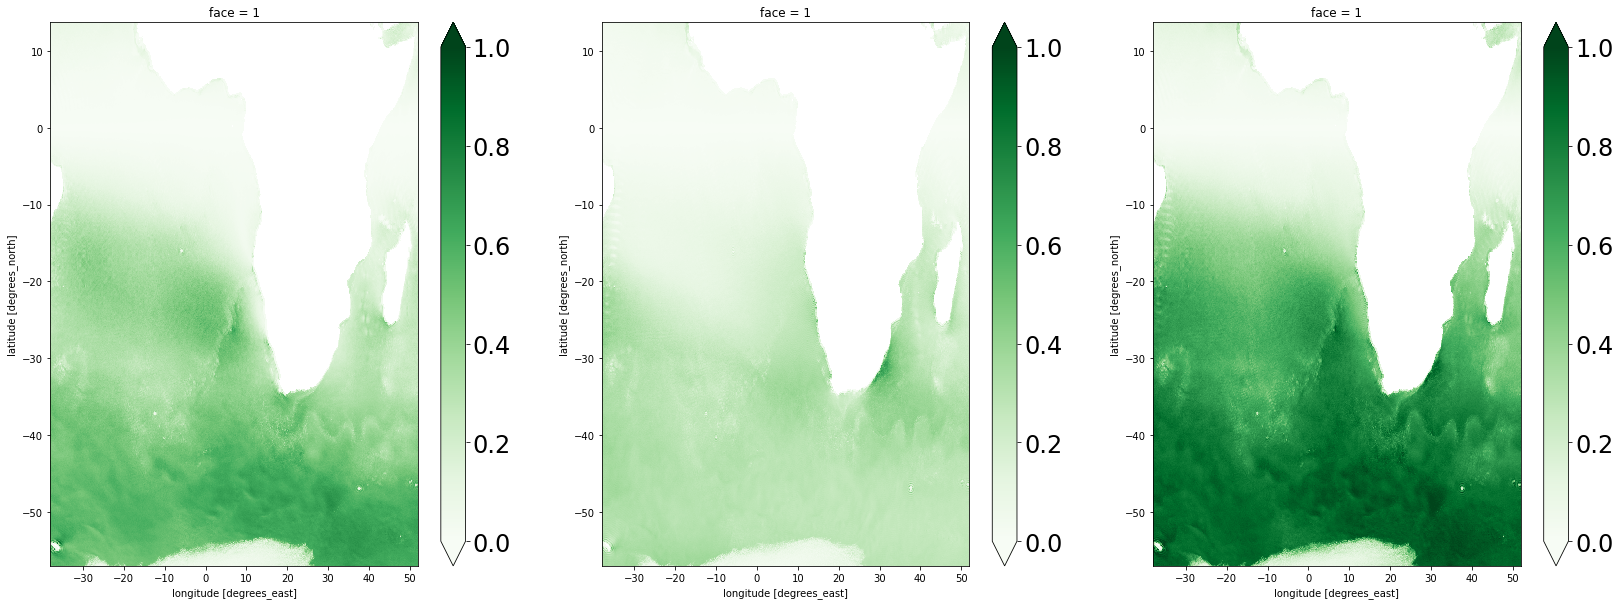

In [26]:
fig, ax = plt.subplots(figsize=(28,16))

ax = plt.subplot(221)
cax = Hx.isel(face=1).plot(x='XC', y='YC', vmin = 0, vmax=1, cmap = 'Greens', add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=24)
cbar.set_label('', fontsize=24)

ax = plt.subplot(222)
cax = Hy.isel(face=1).plot(x='XC', y='YC', vmin = 0, vmax=1, cmap = 'Greens', add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=24)
cbar.set_label('', fontsize=24)

ax = plt.subplot(223)
cax = (Hx+Hy).isel(face=1).plot(x='XC', y='YC', vmin = 0, vmax=1, cmap = 'Greens', add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=24)
cbar.set_label('', fontsize=24)

In [20]:
def quick_llc_plot(data, axis_off=False, **kwargs):
    face_to_axis = {0: (2, 0), 1: (1, 0), 2: (0, 0),
                    3: (2, 1), 4: (1, 1), 5: (0, 1),
                    7: (0, 2), 8: (1, 2), 9: (2, 2),
                    10: (0, 3), 11: (1, 3), 12: (2, 3)}
    transpose = [7, 8, 9, 10, 11, 12]
    gridspec_kw = dict(left=0, bottom=0, right=4, top=4, wspace=0, hspace=0)
    fig, axes = plt.subplots(nrows=3, ncols=4, gridspec_kw=gridspec_kw)
    for face, (j, i) in face_to_axis.items():
        data_ax = data.isel(face=face)
        ax = axes[j,i]
        yincrease = True
        if face in transpose:
            data_ax = data_ax.transpose()
            yincrease = False
        data_ax.plot(ax=ax, yincrease=yincrease, **kwargs)
        if axis_off:
            ax.axis('off')
        ax.set_title('')

In [21]:
out_dir_zarr = '/home/datawork-lops-osi/equinox/mit4320/zarr/'
ice = xr.open_zarr(out_dir_zarr+'sea_ice_mask.zarr').isel(j=slice(0 ,None, 4), i=slice(0, None, 4))
ice

<xarray.Dataset>
Dimensions:  (face: 13, i: 1080, j: 1080)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
  * j        (j) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
Data variables:
    AREA     (face, j, i) float64 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the

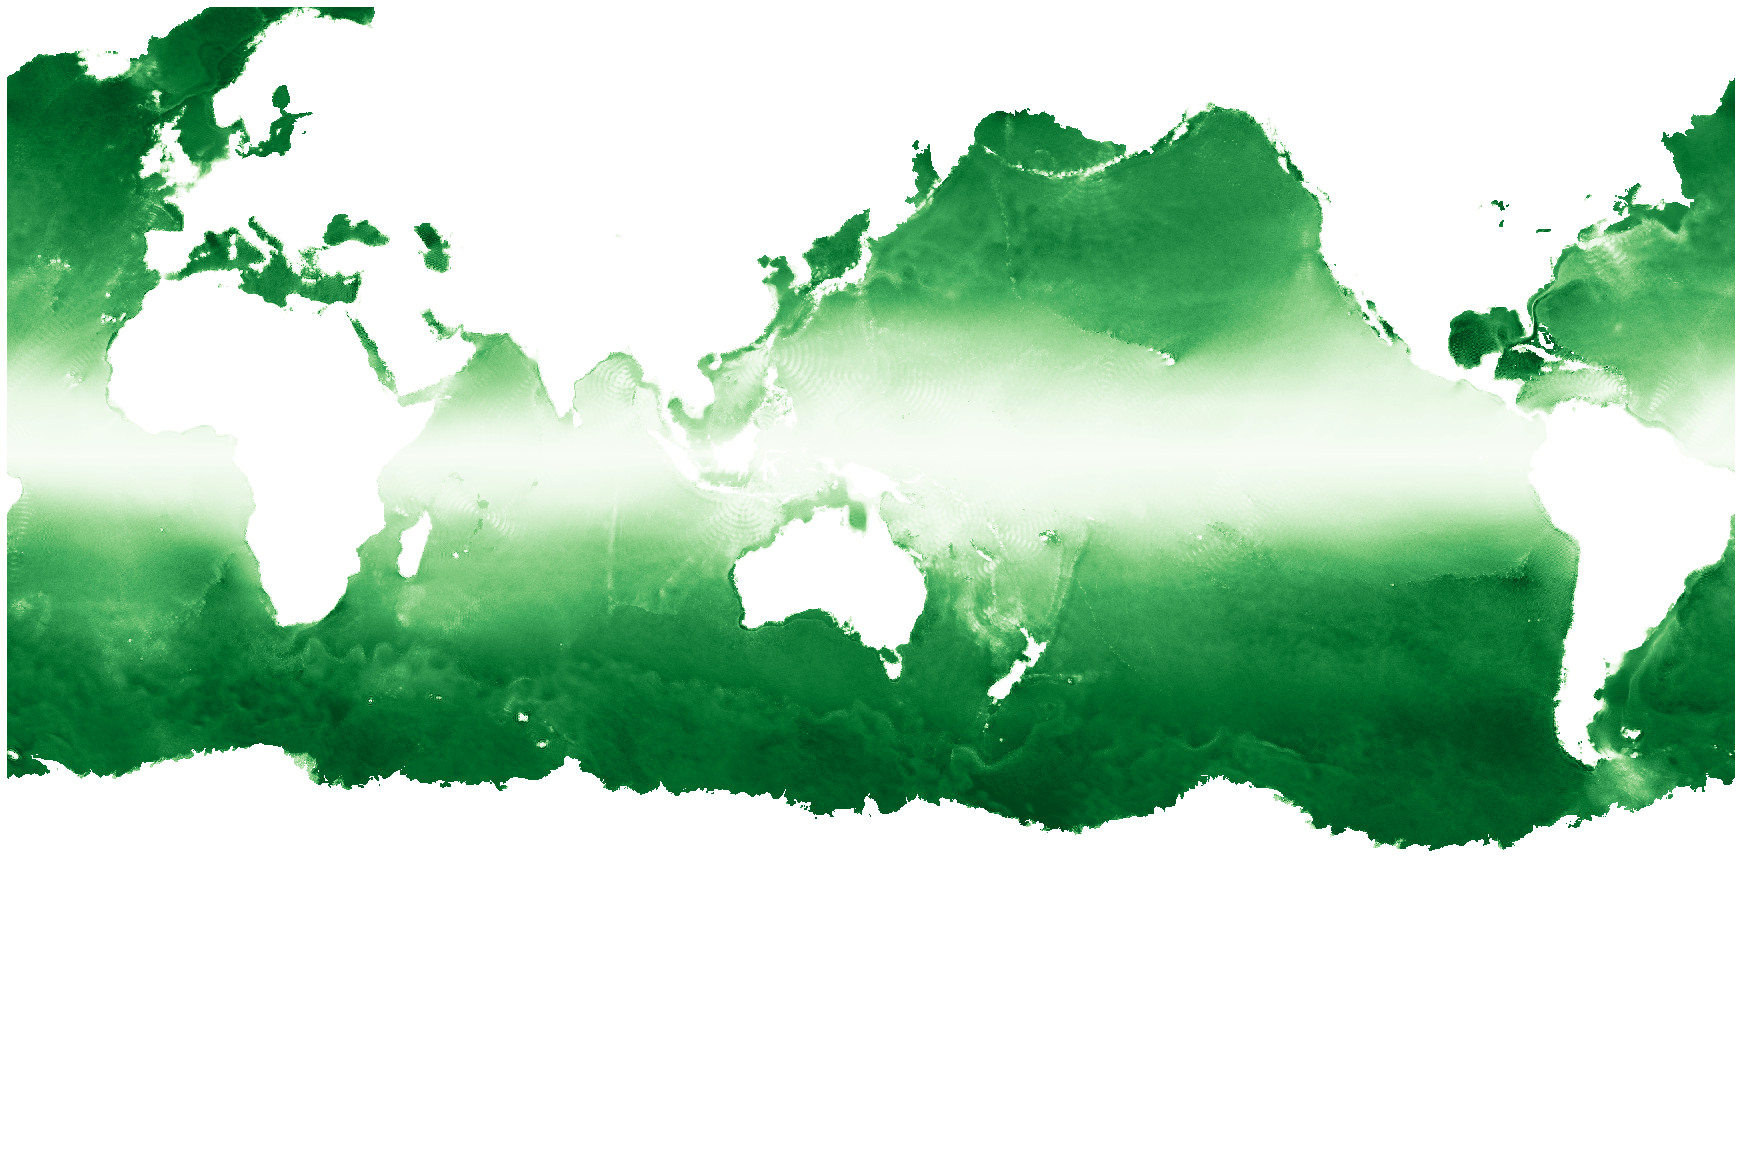

In [24]:
quick_llc_plot( (Hx+Hy).where(ice.AREA>0), vmin=0, vmax=1, add_colorbar=False, axis_off=True, cmap = 'Greens')

In [ ]:
Tau_ELD_rms = np.sqrt(ds_TAU.oceTAUX_ELD_rms**2 + ds_TAU.oceTAUY_ELD_rms**2)
Residuals_rms = np.sqrt(ds_resi.residuals_u_rms**2 + ds_resi.residuals_v_rms**2)
Diff_rms = Residuals_rms - Tau_ELD_rms

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the

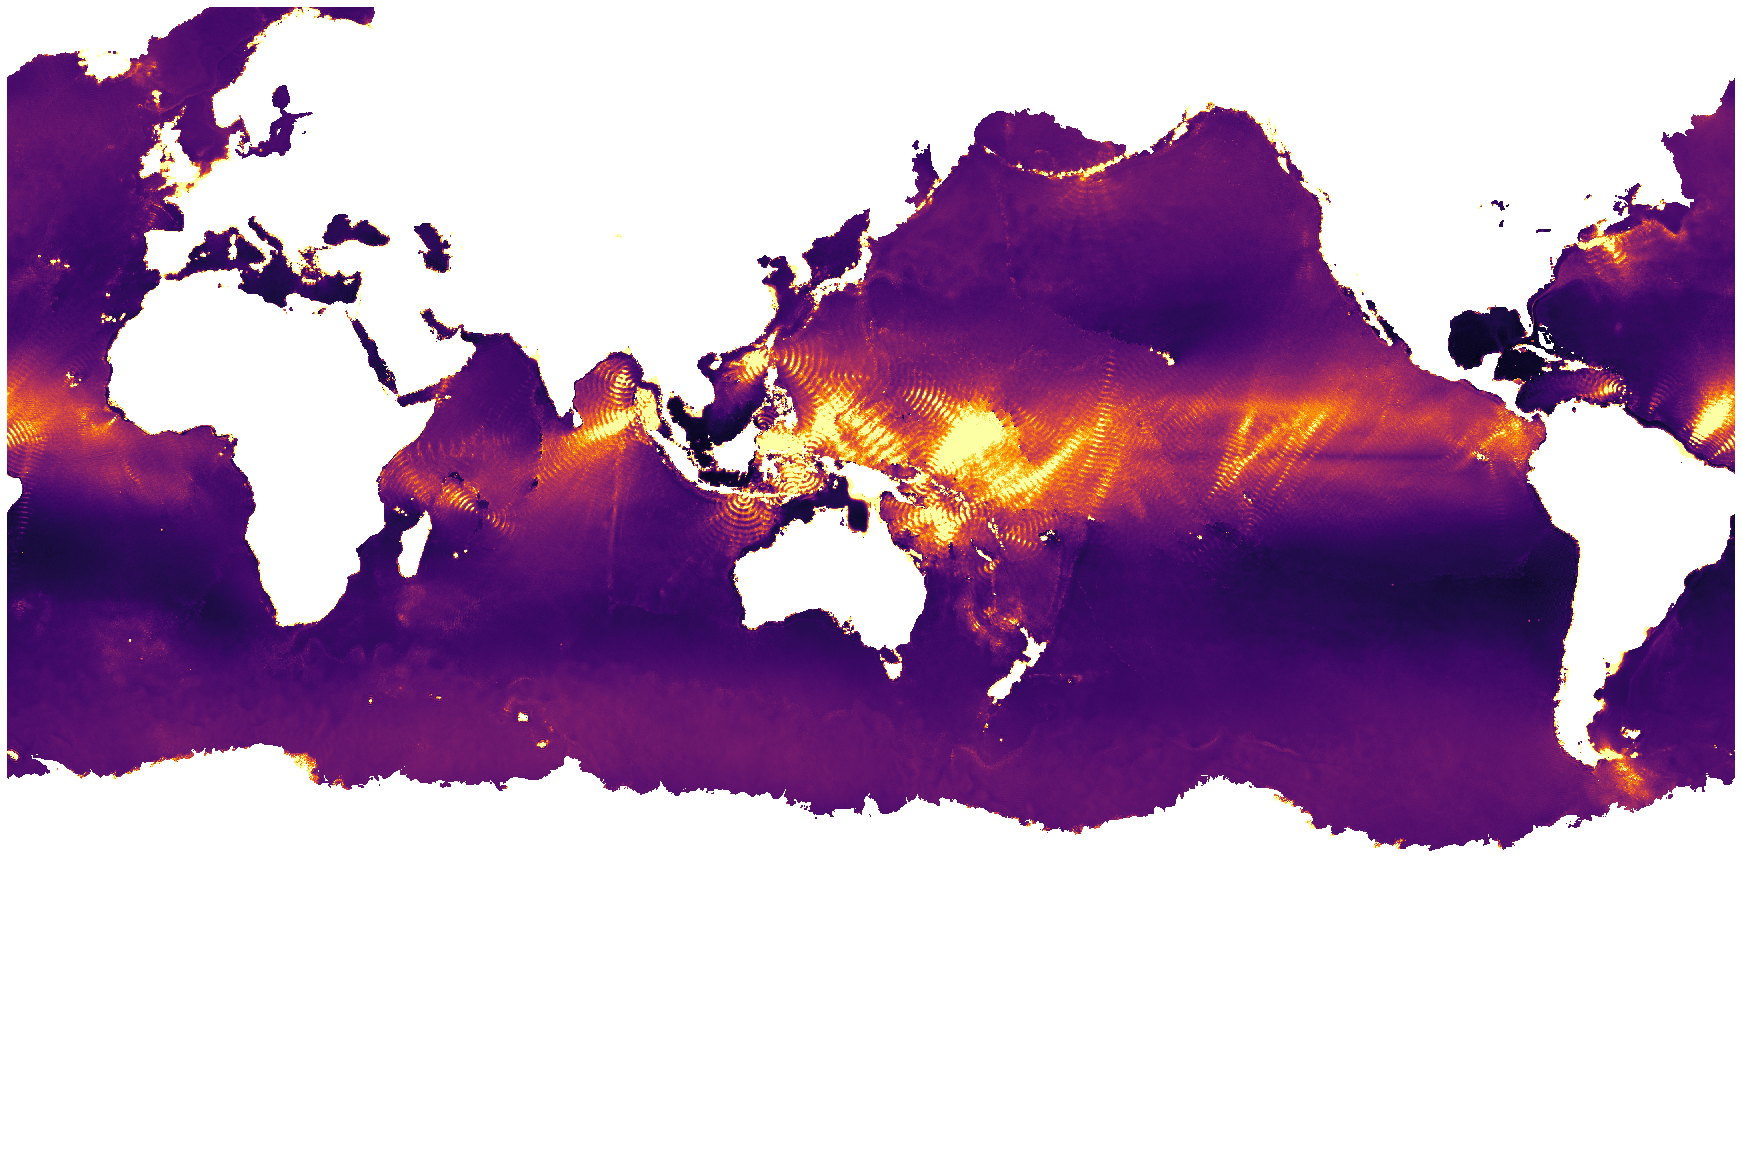

In [48]:
quick_llc_plot( Diff_rms.where(ice.AREA>0), vmin = 0, vmax=4e-5, add_colorbar=False, axis_off=True, cmap = 'inferno')

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the

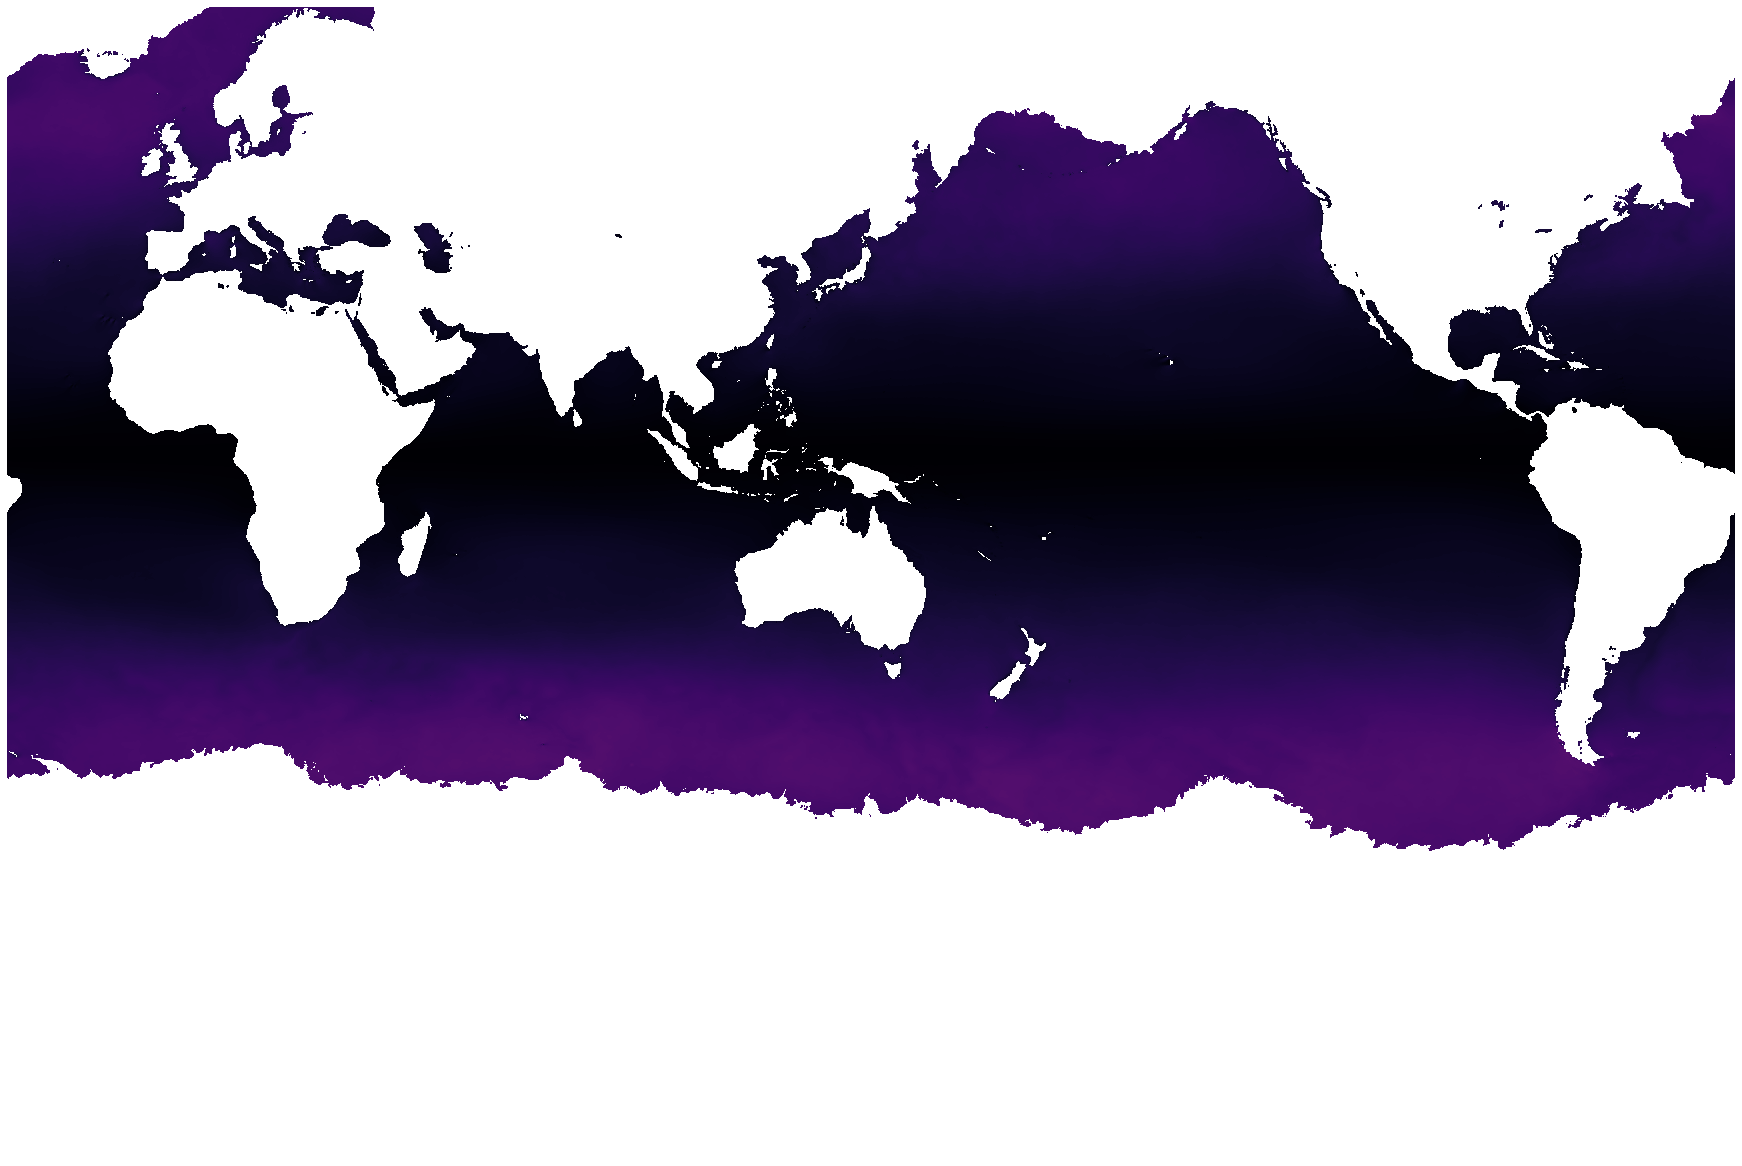

In [47]:
quick_llc_plot( Tau_ELD_rms.where(ice.AREA>0), vmin = 0, vmax=4e-5, add_colorbar=False, axis_off=True, cmap = 'inferno')

In [50]:
cluster.close()

RuntimeError: Command exited with non-zero exit code.
Exit code: 35
Command:
qdel 9178799 9178798
stdout:

stderr:
qdel: Job has finished



distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1276, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures._base.CancelledError
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1005, in _reconnect
    await self._close()
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1